In [5]:
import numpy as np
import os

import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
from statistics import median
import progressbar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter1d

In [6]:
# global variables
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

# pure metrics = 0, binning hist = 1
model = 0

In [39]:
%matplotlib inline
def createSaveFolder():
    if not os.path.isdir('datasets'):
        os.mkdir('datasets')
    save_folder = None
    if model == 0:
        save_folder = 'datasets/skeleton/'
    elif model == 1:
        save_folder = 'datasets/bin/'
    if not os.path.isdir(save_folder):
        os.mkdir(save_folder)
    return save_folder
    
save_folder = createSaveFolder()

In [8]:
# normalizes a matrix
def normalize(matrix):
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)
    # return matrix

In [9]:
# Get the distance to every single point 
def getAllDistances(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    norm = normalize(dist)
    max_dist = max(dist.flatten())
    return dist, norm, max_dist

In [10]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb):
    mat = matFile[numb]
    z = mat[2]
    num_pts = int(matFile.shape[2])
    height_diff = []

    for i in range(num_pts):
        for j in range(num_pts):
            if np.nan in [z[i], z[j]]:
                height_diff.append(np.nan)
            else:
                height_diff.append(np.abs(z[i]-z[j]))

    # normalizes height data
    height = np.array(height_diff).reshape(num_pts, num_pts)
    norm = normalize(height)
    max_height = max(height.flatten())
    return height, norm, max_height


In [11]:
# Get the angle to every single point 
def getAllAngles(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    norm = normalize(angle)
    max_angle = max(angle.flatten())
    return angle, norm, max_angle

In [61]:
def getData(data, numb): 
    if model == 0:
        return pureData(data, numb)
    # elif model == 1:
    #     return binData(data, numb)

In [63]:
def pureData(data, numb): 
    cnn_inputs = []
    max_dist_list = []
    max_height_list = []
    max_angle_list = []

    bar = progressbar.ProgressBar()
    for i in bar(range(numb)):
        dist, norm_dist, max_dist = getAllDistances(data, i) 
        height, norm_height, max_height = getAllHeights(data, i)
        angle, norm_angle, max_angle = getAllAngles(data, i)

        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

            big = output[:,:13]
            where_are_NaNs = np.isnan(big)
            big[where_are_NaNs] = 0
            max_dist_list.append(np.max(big[0]))
            max_height_list.append(np.max(big[1]))
            max_angle_list.append(np.max(big[2]))
    # median 
    avg_max_dist = median(max_dist_list)
    avg_max_height = median(max_height_list)
    avg_max_angle = median(max_angle_list)
    avg_max = [avg_max_dist, avg_max_height, avg_max_angle]

    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    final = []
    for i in range(len(cnn_inputs)):
        for j in range(3):
            final.append(cnn_inputs[i][j]/avg_max[j])
    
    cnn_inputs = np.array(final).reshape((cnn_inputs.shape[0], 39))

    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [4]:
def binData(data, numb): 
    cnn_inputs = []
    max_dist_list = []
    max_height_list = []
    max_angle_list = []

    bar = progressbar.ProgressBar()

    for i in bar(range(numb)):
        dist, norm_dist, max_dist = getAllDistances(data, i) 
        height, norm_height, max_height = getAllHeights(data, i)
        angle, norm_angle, max_angle = getAllAngles(data, i)

        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

            big = output[:,:13]
            where_are_NaNs = np.isnan(big)
            big[where_are_NaNs] = 0
            max_dist_list.append(np.max(big[0]))
            max_height_list.append(np.max(big[1]))
            max_angle_list.append(np.max(big[2]))
    # median 
    avg_max_dist = median(max_dist_list)
    avg_max_height = median(max_height_list)
    avg_max_angle = median(max_angle_list)
    avg_max = [avg_max_dist, avg_max_height, avg_max_angle]

    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    final = []
    temp_bin = np.arange(20)/20
    hist_bin = temp_bin.tolist() + [1]
    bar = progressbar.ProgressBar()

    for i in bar(range(len(cnn_inputs))):
        for j in range(3):
            norm = cnn_inputs[i][j]/avg_max[j]
            hist = np.histogram(norm, bins=hist_bin)[0]
            gauss = gaussian_filter1d([float(i) for i in hist], 1)
            final.append(gauss)
    
    cnn_inputs = np.array(final).reshape((cnn_inputs.shape[0], 60))
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs

In [14]:
def trainTest(train_data, test_data, train_labels, test_labels, numb_train, numb_test):
    index_test = np.linspace(0, len(test_labels), num = numb_test, endpoint=False).astype(int)
    pre_train_data = train_data
    pre_train_labels = train_labels
    if numb_train != len(train_data):
        index_train = np.linspace(0, len(train_labels), num = numb_train, endpoint=False).astype(int)
        pre_train_data = train_data[index_train]
        pre_train_labels = train_labels[index_train]
    pre_test_data = test_data[index_test]
    pre_test_labels = test_labels[index_test]
    # -------------------------------------------------------

    # Get measurement data for every 3D point
    print("Getting messurements")
    train_data = getData(pre_train_data, numb_train)
    test_data = getData(pre_test_data, numb_test)

    # Flatten the trian labels to fit dimentions of data
    train_labels = pre_train_labels.flatten()[0:(numb_train*20)]-1
    test_labels = pre_test_labels.flatten()[0:(numb_test*20)]-1
    # -------------------------------------------------------

    # Get index where the data is all 0
    print("Removing nans")
    nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
    nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]
    # Turn data into lists
    train_data_new = list(train_data)
    test_data_new = list(test_data)
    train_labels_new = list(train_labels)
    test_labels_new = list(test_labels)
    # Remove the nan values
    bar = progressbar.ProgressBar()
    for i in bar(nans_train):
        train_data_new.pop(i)
        train_labels_new.pop(i)
    bar = progressbar.ProgressBar()
    for i in bar(nans_test):
        test_data_new.pop(i)
        test_labels_new.pop(i)
    # Turn data back into array
    train_data_new = np.array(train_data_new)
    train_labels_new = np.array(train_labels_new)
    test_data_new = np.array(test_data_new)
    test_labels_new = np.array(test_labels_new)
    return train_data_new, test_data_new, train_labels_new, test_labels_new

In [15]:
test_file = loadmat('mat_files/bigSet2.mat')
test_data = test_file['bigSet2']

In [ ]:
plt.imshow(test_data[21])
plt.title("X, Y, Z coordinates")
plt.xlabel("Points in frame")
plt.ylabel("Z,     Y,     X")
plt.tight_layout()
plt.show()

In [33]:
train_data_new = None
test_data_new = None
train_labels_new = None
test_labels_new = None
numb_test = None
save_files = False
train = False

if train:
    train_file = loadmat('mat_files/bigSet1.mat')
    test_file = loadmat('mat_files/bigSet2.mat')
    train_data = train_file['bigSet1']
    test_data = test_file['bigSet2']
    train_labels = train_file['labels1']
    test_labels = test_file['labels2']

    # set numb of data used
    # numb_train = len(train_data)
    numb_train = 1000
    numb_test = 1000

    train_data_new, test_data_new, train_labels_new, test_labels_new = trainTest(train_data, test_data, train_labels, test_labels, numb_train, numb_test)
    if (save_files): 
        print("Saving to:", save_folder)
        np.save(save_folder + 'train_data.npy', np.asarray(train_data_new))
        np.save(save_folder + 'train_labels.npy', np.asarray(train_labels_new))
        np.save(save_folder + 'test_data.npy', np.asarray(test_data_new))
        np.save(save_folder + 'test_labels.npy', np.asarray(test_labels_new))
else:
    train_data_new = np.load(save_folder + 'train_data.npy')
    train_labels_new = np.load(save_folder + 'train_labels.npy')
    test_data_new = np.load(save_folder + 'test_data.npy')
    test_labels_new = np.load(save_folder + 'test_labels.npy')
    numb_test = len(test_labels_new)

In [43]:
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels, save):
    ml_train_data = None
    ml_test_data = None
    if model == 0:
        ml_train_data = train_data.reshape(train_data.shape[0], 39)
        ml_test_data = test_data.reshape(test_data.shape[0], 39)
    elif model == 1:
        ml_train_data = train_data.reshape(train_data.shape[0], 60)
        ml_test_data = test_data.reshape(test_data.shape[0], 60)
    ml_train_data = ml_train_data.astype('float32')
    ml_test_data = ml_test_data.astype('float32')

    ml_model = createModel()
    if save:
        ml_folder = os.path.join(save_folder, "training")
        if not os.path.isdir(ml_folder):
            os.mkdir(ml_folder)
        checkpoint_path = ml_folder + "/cp.ckpt"
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

        ml_model.fit(x=ml_train_data,y=train_labels, verbose='auto', batch_size=100, epochs=5, validation_data=(ml_test_data, test_labels), callbacks=[cp_callback])
    else: 
        ml_model.fit(x=ml_train_data,y=train_labels, verbose='auto', batch_size=100, epochs=5, validation_data=(ml_test_data, test_labels))
    
    loss, acc = ml_model.evaluate(ml_test_data, test_labels, verbose=1)
    print("Loss:", loss)
    print("Accuracy:", acc*100)
    return ml_model

# Creates the model for the CNN
def createModel():
    model = Sequential()
    model.add(Dense(640, activation= LeakyReLU()))
    model.add(Dense(320, activation= LeakyReLU()))
    model.add(Dense(80, activation= LeakyReLU()))
    model.add(Dense(len(joint_name), activation = "softmax"))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
def getStoredModel():
    checkpoint_path = save_folder + "training/cp.ckpt"
    skeleton_model = createModel()
    skeleton_model.load_weights(checkpoint_path).expect_partial()

    # Re-evaluate the model
    loss, acc = skeleton_model.evaluate(test_data_new, test_labels_new)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    return skeleton_model

In [34]:
%matplotlib inline
def dispConfMat(skeleton_model):
    test_pred = np.argmax(skeleton_model.predict(test_data_new), axis=-1)
    con_mat = tf.math.confusion_matrix(labels=test_labels_new, predictions=test_pred).numpy()
    row_sums = con_mat.sum(axis=1)
    new_matrix = con_mat / row_sums[:, np.newaxis]
    fig, ax = plt.subplots()
    ax.set_title("Confusion Matrix")
    ax.set_xticks((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))
    ax.set_xticklabels(joint_name, rotation=90)
    ax.set_yticks((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))
    ax.set_yticklabels(joint_name)
    ax.xaxis.tick_top()
    temp = ax.imshow(new_matrix,interpolation='nearest', aspect=1)
    plt.colorbar(temp, ax=ax)
    plt.tight_layout()
    fig.savefig("cm.tiff")

5691/5691 [==============================] - 18s 3ms/step - loss: 0.6440 - accuracy: 0.8331
Restored model, accuracy: 83.31%


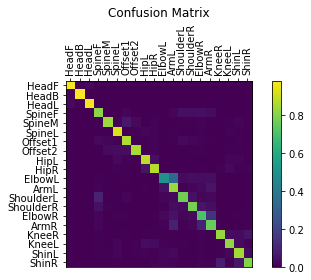

In [48]:
skeleton_model = None
if train:
    skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new, False)
else:
    skeleton_model = getStoredModel()
dispConfMat(skeleton_model)

In [46]:
# Tests individual points and tells you if the CNN worked
def handTest(image_index, test_data, label, model, maxNumb):
    if image_index <= maxNumb:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", maxNumb)

# Showing individual predictions
def predict(data, image_index, label, model):
    img = data[image_index]
    length_flat = len(img)
    length_img = int(length_flat/3)
    img = np.array(img).reshape(3,length_img)
    plt.imshow(img)
    plt.title("Meterics for head points and 10 closest points")
    plt.xlabel("Points in frame")
    plt.ylabel("Height, Angle, Distance ")
    plt.tight_layout()
    plt.show()
    
    pred = model.predict(img.reshape(1, length_flat))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

In [60]:
print(test_data_new.shape)

(182109, 39)


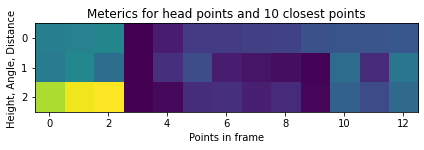

Actual: 18
Predicted: 18
YAY ✿(ᵔ‿ᵔ)


In [49]:
%matplotlib inline
# %matplotlib tk
for i in range(420,421):
    handTest(i, test_data_new, test_labels_new, skeleton_model, numb_test)

In [ ]:
# import h5py
# temporal_file = h5py.File('mat_files/JDM25baseline_Ext4_timematched_controltsne_analysis_struct_mocapdata.mat', 'r') 
# temp_data = temporal_file['alteredM'][:]
# temp_labels = temporal_file['labelsM'][:]
# temporal_file.close()
# copy_data = temp_data.copy()
# copy_labels = temp_labels.copy()

In [ ]:
# new_temp_data = copy_data[:,:,:3000]
# num_fms =  new_temp_data.shape[2]
# num_pts = len(new_temp_data)
# new_temp_labels = copy_labels[:,:num_fms]
# print(new_temp_data.shape, new_temp_labels.shape, num_fms, num_pts)
# print(copy_data.shape)

(20, 3, 3000) (20, 3000) 3000 20
(20, 3, 7534093)


In [50]:
temporal_file = loadmat('mat_files/bigSet3.mat')
temp_data = temporal_file['bigSet3']
temp_labels = temporal_file['labels3']
new_data = temp_data.copy()
new_labels = temp_labels.copy()
new_data_2 = np.transpose(new_data,(2,1,0))
new_labels_2 = new_labels.T

In [76]:
print(new_data_2.shape)

(20, 3, 221157)


In [77]:
new_temp_data = new_data_2[:,:,100000:106000]
num_fms =  new_temp_data.shape[2]
num_pts = len(new_temp_data)
new_temp_labels = new_labels_2[:,:num_fms]
print(new_temp_data.shape, new_temp_labels.shape, num_fms, num_pts)

(20, 3, 6000) (20, 6000) 6000 20


In [79]:
%matplotlib inline
def processTempData(new_temp_data, new_temp_labels):
    time_pts = []
    bar = progressbar.ProgressBar()
    for i in bar(range(new_temp_labels.shape[1])):
        label = np.array(new_temp_labels[:,i])
        data = new_temp_data[:,:,i]
        stack = np.column_stack((data, label))
        stack = np.array(sorted(stack,key=lambda x: x[3]))
        time_pts.append(stack[:,:3])
    time_pts = np.array(time_pts).reshape(num_fms, 3*num_pts).T
    plt.imshow(time_pts, interpolation='nearest', aspect="auto")
    plt.title("Full segments")
    plt.xlabel("Frames")
    plt.ylabel("XYZ points")
    plt.show()
    return time_pts

100% (6000 of 6000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


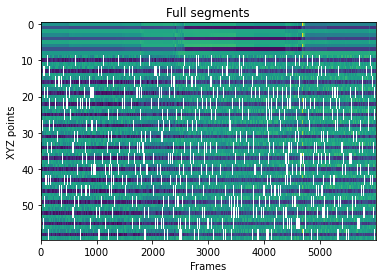

In [80]:
test_pts = processTempData(new_temp_data, new_temp_labels)

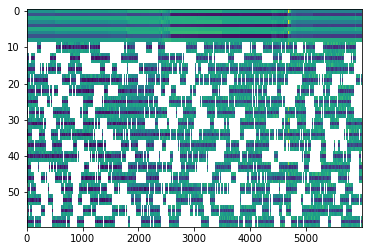

In [94]:
import random
time_pts = test_pts.copy()
for i in range(3,num_pts):
    times = random.randint(10,20)
    for j in range(times):
        length_gap = random.randint(100, 200)
        start_gap = random.randint(0,num_fms-1)
        end_gap = start_gap + length_gap
        time_pts[i*3][start_gap:end_gap] = np.nan
        time_pts[i*3+1][start_gap:end_gap] = np.nan
        time_pts[i*3+2][start_gap:end_gap] = np.nan
%matplotlib inline
plt.imshow(time_pts, interpolation='nearest', aspect="auto")
plt.show()

In [82]:
input_pts = time_pts.reshape(num_pts, 3, num_fms).T
processed_time = getData(input_pts, len(input_pts))
process_pts = None
if model == 0:
    process_pts = processed_time.reshape(num_fms, num_pts, 39)
elif model == 1: 
    process_pts = processed_time.reshape(num_fms, num_pts, 60)
processed = np.transpose(process_pts,(1, 0, 2))

100% (6000 of 6000) |####################| Elapsed Time: 0:00:20 Time:  0:00:20


In [83]:
chunks = []
temp = np.ones((num_pts,num_fms))
bar = progressbar.ProgressBar()
# run through all the registered points (0,22)
for i in bar(range(num_pts)):
    # get every third row
    row = i*3
    row_list = []
    temp_list = []

    # run through length of each row (0,3000)
    for j in range(num_fms): 
        # not a nan, add index to list
        if not np.isnan(time_pts[row][j]):
            temp_list.append(j)
            temp[i][j] = temp[i][j]*2
        # if element is a nan and the current list is not empty
        elif len(temp_list) > 0:
            # add list to output and clear the list
            row_list.append([temp_list[0], temp_list[-1]])
            temp_list = []
    # edge case, add to output if the list still contains values
    if len(temp_list) > 0:
        row_list.append([temp_list[0], temp_list[-1]])
    chunks.append(row_list)

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [84]:
# Check the chunk list
chunks = np.array(chunks, dtype=list)
for i in range(len(chunks)):
    print("Point: "+str(i) +", Chunks: " + str(len(chunks[i])))

Point: 0, Chunks: 1
Point: 1, Chunks: 1
Point: 2, Chunks: 1
Point: 3, Chunks: 503
Point: 4, Chunks: 462
Point: 5, Chunks: 421
Point: 6, Chunks: 552
Point: 7, Chunks: 502
Point: 8, Chunks: 494
Point: 9, Chunks: 493
Point: 10, Chunks: 501
Point: 11, Chunks: 470
Point: 12, Chunks: 523
Point: 13, Chunks: 478
Point: 14, Chunks: 524
Point: 15, Chunks: 443
Point: 16, Chunks: 473
Point: 17, Chunks: 493
Point: 18, Chunks: 463
Point: 19, Chunks: 443


In [85]:
temporal_data = []
# loop through all the points (0,22)
for i in range(len(chunks)):
    prediction = []
    confidence = []
    data = chunks[i] # list of chunks in a given row
    model_pred = skeleton_model.predict(processed[i])
    print("Point: "+ str(i) + ", Segments: " + str(len(data)))
    for j in range(len(data)):
        seg_range = data[j] 
        lower = seg_range[0]
        upper = seg_range[1]+1
        seg_len = upper - lower
        seg = model_pred[lower:upper]
        
        # get the predictions per frame
        pred_frame = seg.argmax(axis=-1)
        # adding up all the confident scores together
        conf_sum = np.sum(seg, axis=0)/seg_len
        # get the prediction with highest confident score
        pred = conf_sum.argmax()
        # get the highest confident score 
        conf = conf_sum.max()
        # count how many times the prediction apppears per chunk 
        pred_count = np.sum(pred == pred_frame)
        # get the percent of how many times it appears 
        pred_mode = pred_count/seg_len
        # get the list of predictions in decending order 
        rank_pred = np.argsort(conf_sum.argsort())

        # print(i, ": (", j+1, "/", len(data), "):", pred ,"[", lower, ",", upper, "], (", pred_count, "/", seg_len, ") =", pred_mode, ",", conf)
        add_data = [i, rank_pred, seg_range, pred_count, seg_len, pred_mode, conf, conf_sum]
        prediction.append(add_data)
    temporal_data.append(prediction)


Point: 0, Segments: 1
Point: 1, Segments: 1
Point: 2, Segments: 1
Point: 3, Segments: 503
Point: 4, Segments: 462
Point: 5, Segments: 421
Point: 6, Segments: 552
Point: 7, Segments: 502
Point: 8, Segments: 494
Point: 9, Segments: 493
Point: 10, Segments: 501
Point: 11, Segments: 470
Point: 12, Segments: 523
Point: 13, Segments: 478
Point: 14, Segments: 524
Point: 15, Segments: 443
Point: 16, Segments: 473
Point: 17, Segments: 493
Point: 18, Segments: 463
Point: 19, Segments: 443


In [86]:
# save(folder + 'temporal_data.npy', asarray(temporal_data, dtype=object))
# temporal_data = load(folder + 'temporal_data.npy', allow_pickle=True)

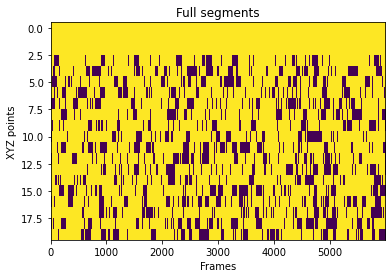

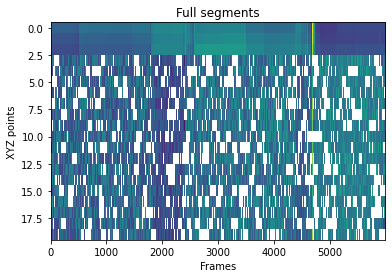

In [87]:
%matplotlib inline
temp_new = np.ones((num_pts,num_fms))
for i in range(len(temporal_data)):
    for j in range(len(temporal_data[i])):
        start = temporal_data[i][j][2][0]
        end = temporal_data[i][j][2][1] + 1
        for k in range(start, end):
            temp_new[i][k] +=1
plt.imshow(temp_new, interpolation='nearest', aspect="auto")
plt.title("Full segments")
plt.xlabel("Frames")
plt.ylabel("XYZ points")
plt.show()

plt.imshow(time_pts[::3], interpolation='nearest', aspect="auto")
plt.title("Full segments")
plt.xlabel("Frames")
plt.ylabel("XYZ points")
plt.show()

In [88]:
temp_copy = temporal_data.copy()
temp_data = np.array(temp_copy, dtype=object)
chunk_data = []

for i in range(20):
    chunk_data.append([])    
# putting the preditions into buckets
for i in range(num_pts):
    index = temp_data[i]
    for j in range(len(index)):
        chunk_data[index[j][1].argmax()].append(index[j])
for i in range(len(chunk_data)):
    print(i, len(chunk_data[i]))

0 4
1 1
2 1
3 339
4 170
5 330
6 90
7 327
8 221
9 61
10 933
11 1564
12 568
13 32
14 99
15 440
16 56
17 362
18 1570
19 1073


In [89]:
def squish(chunk_data):
    unprocessed_pts = []
    processed_pts = []
    # squish all the data points
    for i in range(20): 
        numb_index = []
        unprocessed = []
        bounds = None
        current = chunk_data[i]
        cert = chunk_data[i]
        sorted_current = sorted(current,key=lambda x: x[4])
        
        for j in reversed(range(len(sorted_current))):
            input_index = sorted_current[j]
            current_bounds = np.arange(input_index[2][0], input_index[2][1]+1).tolist()

            if len(numb_index) == 0:
                numb_index.append(input_index)
                bounds = current_bounds
            else:
                same = list(set(current_bounds) & set(bounds)) # gets overlapping elements 
                # no overlapp between the two lists
                if len(same) == 0:
                    numb_index.append(input_index)
                    bounds += current_bounds
                else: #if there is overlap between the two lists
                    if current_bounds[0] in bounds or current_bounds[-1] in bounds:
#                         print(str(i) + ") Can't add index in range [" + str(current_bounds[0]) + ", " + str(current_bounds[-1]) + "] to [" + str(bounds[0])+ ", " + str(bounds[-1]) + "]")
                        unprocessed.append(input_index)
                        pass
                    elif current_bounds[0] in bounds:
                        print("Lower bound inside current bounds")
                        pass
                    elif current_bounds[-1] in bounds:
                        print("Upper bound inside current bounds")
                        pass
            bounds = sorted(bounds)
        processed_pts.append(numb_index)
        unprocessed_pts.append(unprocessed)
    processed_pts = np.array(processed_pts, dtype = object)
    unprocessed_pts = np.array(unprocessed_pts, dtype = object)
    return processed_pts, unprocessed_pts
 

In [90]:
processed_pts, unprocessed_pts = squish(chunk_data)

In [91]:
final_points = []
point_coord = np.ones((60,num_fms))*np.nan

for i in range(len(processed_pts)):
    index = [i*3, i*3+1, i*3+2]
    coord = [[],[],[]]

    for j in range(len(processed_pts[i])):
        seg_range = processed_pts[i][j]
        org_index = seg_range[0]
        start = seg_range[2][0]
        end = seg_range[2][1]
        index_xyz = [org_index*3, org_index*3+1, org_index*3+2]

        for k in range(start, end):
            point_coord[index[0]][k] = time_pts[index_xyz[0]][k]
            point_coord[index[1]][k] = time_pts[index_xyz[1]][k]
            point_coord[index[2]][k] = time_pts[index_xyz[2]][k]
            if np.isnan(time_pts[index_xyz[0]][k]):
                print("big error", seg_range)

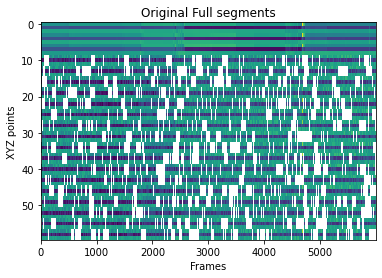

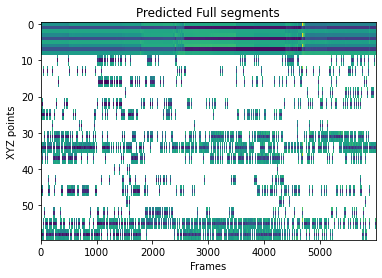

In [92]:
plt.imshow(time_pts, interpolation='nearest', aspect="auto")
plt.title("Original Full segments")
plt.xlabel("Frames")
plt.ylabel("XYZ points")
plt.show()

plt.imshow(point_coord, interpolation='nearest', aspect="auto")
plt.title("Predicted Full segments")
plt.xlabel("Frames")
plt.ylabel("XYZ points")
plt.show()

In [93]:
%matplotlib tk
figure = point_coord.copy()#[:,::5]
connections = [[0,1,2,0], [2,3,4,5], [3,6,7,5], [10, 11, 12, 3, 13, 14, 15], [18,17,8,5,9,16,19]]

fig = plt.figure()
ax = p3.Axes3D(fig, auto_add_to_figure=False )
fig.add_axes(ax)
ax.set_title("Predicted Skeleton")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

def animfunc(t):
    ax.clear()
    
    lines = []
    frame = t
    for conn in connections:
        x = [3*i for i in conn]
        y = [i+1 for i in x]
        z = [i+2 for i in x]
        lines.append(ax.scatter(figure[x, frame], figure[y,frame],  figure[z, frame], color='b', s =10))
        lines.append(ax.plot(figure[x, frame], figure[y,frame],  figure[z, frame], linewidth=3))
    return lines,
        
anim = FuncAnimation(fig, animfunc, frames=figure.shape[1], interval=10, repeat=False)
# for angle in range(0, 720):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)